In [3]:
# %load ../../../preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
#sns.set(font='SimHei')
#plt.rcParams['axes.grid'] = False

import numpy as np

import pandas as pd
pd.options.display.max_rows = 20

#import sklearn

#import itertools

import logging
logger = logging.getLogger()

决策树简介和 Python 实现
======================
参考：

+ [Building a decision tree from scratch - a beginner tutorial](http://www.patricklamle.com/Tutorials/Decision%20tree%20python/tuto_decision%20tree.html)

+ 9.2 Tree-Based Methods - The Elements of Statistical Learning

+ [Classification and Regression Trees (CART) Theory and Applications](http://edoc.hu-berlin.de/master/timofeev-roman-2004-12-20/PDF/timofeev.pdf)

#### 0. 基本介绍
本文主要是参照 Tree-Based Methods - The Elements of Statistical Learning 来实现一个简化版范例，其算法是 CART。

决策树的思想本身非常朴素，关于它的基本介绍在网上已经非常丰富，比如：

+ [算法杂货铺——分类算法之决策树(Decision tree)](http://www.cnblogs.com/leoo2sk/archive/2010/09/19/decision-tree.html)

其主要问题是在每次决策时找到一个分割点，让生成的子集尽可能地纯净。这里涉及到四个问题:

1. 如何分割样本？

2. 如何评价子集的纯净度？

3. 如何找到单个最佳的分割点，其子集最为纯净？

4. 如何找到最佳的分割点序列，其最终分割子集总体最为纯净？

接下来，围绕上述问题，一一概要说明，并加以演示。

#### 加载数据

古话说，「三军未动，粮草先行」。

我们先加载演示数据，使用的是 sklearn 自带的测试用例。

In [4]:
from sklearn.datasets import load_iris
data = load_iris()

In [5]:
# 准备特征数据
X = pd.DataFrame(data.data, 
                 columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
X.head(2)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


In [6]:
# 准备标签数据
y = pd.DataFrame(data.target, columns=['target'])
y.replace(to_replace=range(3), value=data.target_names, inplace=True)
y.head(3)

,target
0,setosa
1,setosa
2,setosa


In [7]:
# 组建样本 [特征，标签]
samples = pd.concat([X, y], axis=1) #, keys=["x", "y"])
samples.head(3)

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


#### 1.0 如何分割样本
决策树的分割方法是取一个特征 $f$ 和阈值 $t$，以此为界将样本 $X$ 拆分为两个子集 $X_l, X_r$。其数学表达形同：

\begin{align}
    X = \begin{cases}
        X_l, \ \text{if } X[f] < t \\
        X_r, \ \text{if } X[f] \geq t
    \end{cases}
\end{align}

In [8]:
def splitter(samples, feature, threshold):
    # 按特征 f 和阈值 t 分割样本
    
    left_nodes = samples.query("{f} < {t}".format(f=feature, t=threshold))
    right_nodes = samples.query("{f} >= {t}".format(f=feature, t=threshold))
    
    return {"left_nodes": left_nodes, "right_nodes": right_nodes}

In [9]:
split = splitter(samples, "sepal_length", 5)

# 左子集
x_l = split["left_nodes"].loc[:, "target"].value_counts()
x_l

setosa        20
versicolor     1
virginica      1
Name: target, dtype: int64

In [10]:
# 右子集
x_r = split["right_nodes"].loc[:, "target"].value_counts()
x_r

virginica     49
versicolor    49
setosa        30
Name: target, dtype: int64

#### 2. 如何评价子集的纯净度？

从常理来说，我们希望分割子集尽可能地纯净，最好是单个子集就只含有一类标签，从而保证决策结果精准。

那么什么样的评价函数，可以用来度量各子集的纯净度呢？

以刚才计算结果为例， $x_l$ 主要标签是 setosa，非常纯净，而 $x_r$ 则三种标签势均力敌，非常混杂。所以思路是，若一种标签在子集中占比非常大，则此子集就较纯净；若各标签占比差别不大，就较为混杂。

常用的评价函数正是计算各标签 $c_k$ 在子集中的占比 $p_k = c_k / \sum (c_k)$，并通过组合 $p_k$ 来描述占比集中或分散。

In [11]:
def calc_class_proportion(node):
    # 计算各标签在集合中的占比
    
    y = node["target"]
    return y.value_counts() / y.count()

In [12]:
calc_class_proportion(split["left_nodes"])

setosa        0.909091
versicolor    0.045455
virginica     0.045455
Name: target, dtype: float64

In [13]:
calc_class_proportion(split["right_nodes"])

virginica     0.382812
versicolor    0.382812
setosa        0.234375
Name: target, dtype: float64

主要的评价函数有三种，它们评价的是集合的不纯度（值越大，集合越混杂）。

先做些数学定义以便于描述：     
假设对于集合 $m$ 有 $N_m$ 个样本，可分割成 $R_m$ 子集。     
若总的标签类别有 $K$ 种，则标签 $k$ 在此集合中的占比为：

\begin{equation}
    \hat{p}_{m k} = \frac{1}{N_m} \displaystyle \sum_{x_i \in R_m} I(y_i = k)
\end{equation}

且令标签 $k$ 是占比最大的标签，即 $k(m) = \operatorname{arg max}_k \hat{p}_{m k}$.

##### 1. Misclassification error
我们一般把集合的分类结果定义为占比最大的标签，那么落在此集合中的其它标签就是误分类。其比率是 $1 - \hat{p}_{m k}(m)$.

In [14]:
def misclassification_error(node):
    p_mk = calc_class_proportion(node)
    
    return 1 - p_mk.max()

In [15]:
misclassification_error(split["left_nodes"])

0.090909090909090939

In [16]:
misclassification_error(split["right_nodes"])

0.6171875

对于二分类问题，

In [17]:
binary_class = pd.Series(np.arange(0, 1.01, 0.01)).to_frame(name="p")
binary_class["1-p"] = 1 - binary_class["p"]
binary_class.head(3)

,p,1-p
0,0.00,1.00
1,0.01,0.99
2,0.02,0.98


误分类率和占比 $p$ 的关系可划图为：

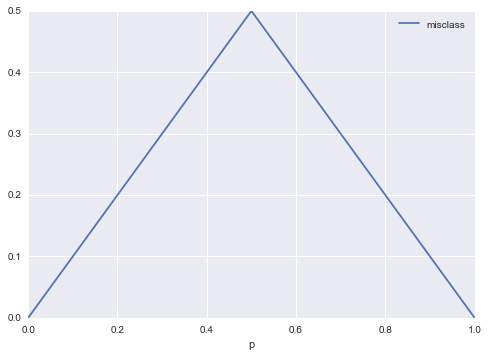

In [18]:
binary_class["misclass"] = binary_class.apply(lambda x: 1 - x.max(), axis=1)
binary_class.plot(x="p", y="misclass")

当 $p=0.5$，两种标签各占一半，不纯度最高；当 $p=0$ 或 $p=1$, 只含有其中一种标签时，不纯度最低。

##### 2. Gini index
这里的基尼系数并非是经济上测量分配公平的指标。

它的思路是从集合中随机抽取元素 $a \in K_p$，再以 $K_p$ 在集合中的分布为参考随机给 $a$ 分配标签，那么误分配率就是基尼系数。

具体到决策树的节点 $m$ 上，标签 $k_i$ 的占比为 $p_{k_i m}$。则抽中属于标签 $k_i$ 的元素概率是 $p_{k_i m}$，误分配到其它标签的概率是 $\sum_{k' \neq k_i} p_{k_i m} p_{k' m}$。对于整个集合的标签则是：

\begin{equation}
    G(m) = \displaystyle \sum_{k \neq k'} p_{k m} p_{k' m} \, \overset{乘法分配律}{=} \sum_{k = 1}^{K} p_{k m} (1 - p_{k m})
\end{equation}

In [19]:
def gini_index(node):
    p_mk = calc_class_proportion(node)
    
    return (p_mk * (1 - p_mk)).sum()

In [20]:
gini_index(split["left_nodes"])

0.1694214876033058

In [21]:
gini_index(split["right_nodes"])

0.6519775390625

在二分类中，基尼系数和占比 $p$ 的关系可划图为：

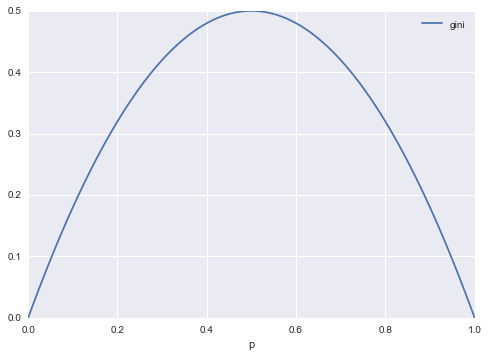

In [22]:
binary_class["gini"] = (binary_class["p"] * binary_class["1-p"] * 2)
binary_class.plot(x="p", y="gini")

##### 3. Cross-entropy
ref:    
[Qualitively what is Cross Entropy](http://stats.stackexchange.com/questions/80967/qualitively-what-is-cross-entropy)

这个损失函数的思路来源于信息论：若某事件的发生概率是 $p$，则需至少 $\log_2 (1/p)$ 位编码。那么对于所有事件，其最优编码的平均字长为 $\sum_i p_i \log_2 (1 / p_i)$。

借用其思路，对于节点来说，其内容越混杂，就需要越多字长来区分。所以这里 cross-entropy 定义为：

\begin{equation}
    C(m) = \displaystyle \sum_{k=1}^K p_{m k} \log (1 / p_{m k}) \, = - \sum_{k=1}^K p_{m k} \log p_{m k}
\end{equation}

In [23]:
def cross_entropy(node):
    p_mk = calc_class_proportion(node)
    
    return - (p_mk * p_mk.apply(np.log)).sum()

In [24]:
cross_entropy(split["left_nodes"])

0.36764947740014225

In [25]:
cross_entropy(split["right_nodes"])

1.075199711851601

在二分类中，cross-entropy 和占比 $p$ 的关系可划图为：

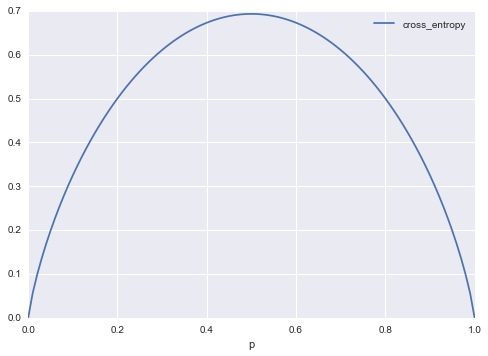

In [26]:
x = binary_class[["p", "1-p"]]
binary_class["cross_entropy"] = -(x * np.log(x)).sum(axis=1)
binary_class.plot(x="p", y="cross_entropy")

在二分类问题中，三种评价函数的比较如图:

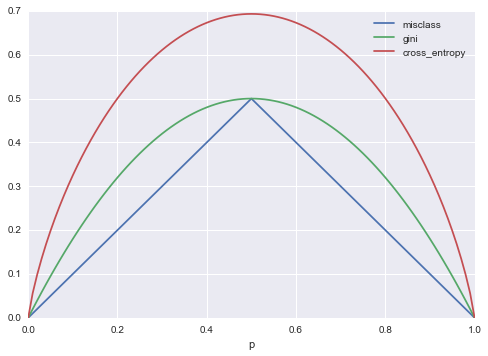

In [27]:
binary_class.plot(x="p", y=["misclass", "gini", "cross_entropy"])

为了便于比较，我们将 cross_entropy 也放缩到 $(0.5, 0.5)$。

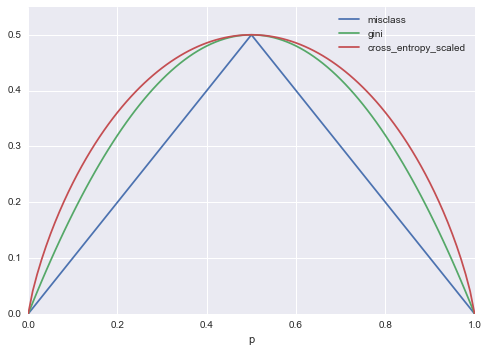

In [28]:
binary_class["cross_entropy_scaled"] = binary_class["cross_entropy"] / binary_class["cross_entropy"].max() * 0.5
binary_class.plot(x="p", y=["misclass", "gini", "cross_entropy_scaled"], ylim=[0,0.55])

可以看到，识分类率在整个区间是均一的，而 cross_entropy 越靠近纯净，其值变化越剧烈。所以 cross_entropy 对纯净更敏感的特性，有利于让结果子集更纯净，其使用相对较多。

####  3. 如何找到单个最佳的分割点，其子集最为纯净？
单个最佳分割点，涉及三个问题：

1. 对于单次分割，分割前和分割后，集合的纯净度提升了多少？

2. 给定一个特征，纯净度提升最大的阈值是多少？

3. 对于多个特征，哪一个特征的最佳阈值对纯净度提升最大？


##### 3.1 对于单次分割，分割前和分割后，集合的纯净度提升了多少？
令测量不纯度的函数为 $G$,    
对一个节点 $m$ 来说，若其按分割方法 $f$ 得到子集 $m_l$ 和 $m_r$，则总的不纯度减少量为：

\begin{equation}
    G(m) - G(m_l) - G(m_r)
\end{equation}

In [29]:
def calc_impurity_measure(node, feathure, threshold, measure, min_nodes=5):
    child = splitter(node, feathure, threshold)
    left = child["left_nodes"]
    right = child["right_nodes"]
    
    if left.shape[0] <= min_nodes or right.shape[0] <= min_nodes:
        return 0
    
    
    impurity = pd.DataFrame([], 
                       columns=["score", "rate"],
                       index=[])
    
    impurity.loc["all"] = [measure(node), node.shape[0]]
    impurity.loc["left"] = [-measure(left), left.shape[0]]
    impurity.loc["right"] = [-measure(right), right.shape[0]]
    
    impurity["rate"] /= impurity.at["all", "rate"]
    
    logger.info(impurity)
    
    return (impurity["score"] * impurity["rate"]).sum()

In [30]:
calc_impurity_measure(samples, "sepal_length", 5, gini_index)

0.08546401515151514

In [31]:
calc_impurity_measure(samples, "sepal_length", 1, gini_index)

0

##### 3.2. 给定一个特征，纯净度提升最大的阈值是多少？

对于一个给定的特征，理论上通过枚取所有可能的阈值，从中找到最大减少量的阈值点，就是此特征的最佳分隔点。

但现实中，很多特征是连续的，或者阈值点太多，全部穷尽并不现实，往往需要用到最优化的寻优方法。这里为了简易起见，我们对特征的值由小到大设了10个分位点，进行计算。

In [32]:
def find_best_threshold(node, feature, measure):
    threshold_candidates = node[feature].quantile(np.arange(0, 1, 0.2))
    
    res = pd.Series([], name=feature)
    for t in threshold_candidates:
        res[t] = calc_impurity_measure(node, feature, t, measure)
    
    logger.info(res)
    
    if res.max() == 0:
        return None
    else:
        return res.argmax()

In [33]:
find_best_threshold(samples, "sepal_width", gini_index)

3.3999999999999999

In [34]:
find_best_threshold(samples, "sepal_length", gini_index)

5.5999999999999996

##### 3.3. 对于多个特征，哪一个特征的最佳阈值对纯净度提升最大？
显然，最暴力的方法是：每次分割，我们穷尽所有特征，即可找到对此节点最佳分割点

In [35]:
def find_best_split(node, measure):
    if node["target"].unique().shape[0] <= 1:
        return None
    
    purity_gain = pd.Series([], name="feature")
    
    for f in node.drop("target", axis=1).columns:
        purity_gain[f] = find_best_threshold(node, f, measure)
        
    if pd.isnull(purity_gain.max()):
        return None
    else:
        best_split = {"feature": purity_gain.argmax(), "threshold": purity_gain.max()}
        best_split["child"] = splitter(node, **best_split)

        return best_split

In [36]:
best_split = find_best_split(samples, gini_index)
[best_split[x] for x in ["feature", "threshold"]]

['sepal_length', 5.5999999999999996]

####  4. 如何找到最佳的分割点序列，其最终分割子集总体最为纯净？
搜索全局最优解在目前还没有有效的方法，所以退一步，我们用贪婪的思想，在每次分割时取最优，希望由局部最优的分割序列能够达到全局最优的效果。

我们使用递归的方法由上而下依次计算，在处理节点顺序时使用深度优先方法组建出决策树。

In [37]:
class BinaryNode:
    def __init__(self, samples, max_depth, measure=gini_index):
        self.samples = samples
        self.max_depth = max_depth
        self.measure = measure
        
        self.is_leaf = False
        self.class_ = None
        
        self.left = None
        self.right = None
        
        self.best_split = None
    
    def split(self, depth):
        if depth > self.max_depth:
            self.is_leaf = True
            self.class_ = self.samples["target"].value_counts().argmax()
            return
        
        best_split = find_best_split(self.samples, self.measure)
        if pd.isnull(best_split):
            self.is_leaf = True
            self.class_ = self.samples["target"].value_counts().argmax()
            return

        self.best_split = best_split
        left = self.best_split["child"]["left_nodes"]
        self.left = BinaryNode(left.drop(best_split["feature"], axis=1), self.max_depth)
        
        right = self.best_split["child"]["right_nodes"]
        self.right = BinaryNode(right.drop(best_split["feature"], axis=1), self.max_depth)

        # 先序深度优先
        self.left.split(depth+1)
        self.right.split(depth+1)

In [38]:
binaryNode = BinaryNode(samples, 3)
binaryNode.split(0)

In [39]:
def show(node, depth):
    if node.left:
        show(node.left, depth+1)
    
    if node.is_leaf:
        print("{}{}".format("\t"*(depth+2), node.class_))
        return 
    else:
        print("{}{}: {}".format("\t"*depth,
                                node.best_split["feature"],
                                node.best_split["threshold"]))
    if node.right:
        show(node.right, depth+1)

In [40]:
show(binaryNode, 0)

				versicolor
	sepal_width: 2.8200000000000003
					setosa
		petal_length: 1.6
						setosa
			petal_width: 0.4
						setosa
sepal_length: 5.6
					versicolor
		sepal_width: 3.1
					versicolor
	petal_length: 4.8
						versicolor
			petal_width: 1.8
						virginica
		sepal_width: 2.9
						virginica
			petal_width: 2.0
						virginica


观察可知，这颗树是有问题的，如 petal_width: 0.4 下两个叶子的类别均是 setosa。在树生成后，可以通过后续的剪枝操作，让整颗树更精简。这里不再详述。